# This Notebook is for analyzing and processing the output of scrap in GCP

Context: Given the significant number of jobs on the LinkedIn site, it isn't easy to do an accurate search.
The search needs to be more precise, even with the site's filters.
With this, we captured this data to develop more precise ways of searching for the perfect match job.  


Solution: Scrap all job data on the LinkedIn site automatically. After collecting the data, try to develop a way to improve the search for relevant opportunities in a personalized way for each profile.  


# Libs

In [27]:
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
import nltk

In [29]:
import pandas_gbq
from google.oauth2 import service_account

from google.cloud import bigquery
%load_ext google.cloud.bigquery

from google.oauth2 import service_account

# Create BigQuery table for save data scraped

In [3]:
credentials = service_account.Credentials.from_service_account_file( 'teste-315517-6ebeb5337f4a.json', )    
pandas_gbq.context.credentials = credentials

In [4]:
project_id = 'teste-315517'
bigquery_client = bigquery.Client(credentials= credentials,project=project_id)

In [6]:
import datetime

In [8]:
now_datetime = datetime.datetime.now()
print(now_datetime)

2023-04-16 17:25:58.476962


In [11]:
schema_scrp=[
    bigquery.SchemaField("title", "STRING"),
    bigquery.SchemaField("location", "STRING"),
    bigquery.SchemaField("company_name", "STRING"),
    bigquery.SchemaField("position_name", "STRING"),
    bigquery.SchemaField("experience_required", "STRING"),
    bigquery.SchemaField("contract_type", "STRING"),
    bigquery.SchemaField("function_name", "STRING"),
    bigquery.SchemaField("company_sector", "STRING"),
    bigquery.SchemaField("description", "STRING"),
    bigquery.SchemaField("link", "STRING"),
    bigquery.SchemaField("now_datetime", "STRING")
]

In [12]:
#criando tabela no bq cpf
table_id = 'teste-315517.teste.raw_from_linkedin'

table = bigquery.Table(table_id, schema=schema_scrp)
table = bigquery_client.create_table(table)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table teste-315517.teste.raw_from_linkedin


# Functions

In [30]:
def clean_column_strings(df):
    """Clean each column of a dirty dataframe

    Args:
        df (dataframe): dataframe to be clean

    Returns:
        dataframe: cleaned dataframe
    """
    
    df['location'] = df['location'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_name'] = df['company_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['experience_required'] = df['experience_required'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['contract_type'] = df['contract_type'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['function_name'] = df['function_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_sector'] = df['company_sector'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    clean = re.compile('<.*?>')
    df['description'] = df['description'].apply(lambda x: re.sub(clean, '', x).replace('\n','').strip())
    df['description'] = df['description'].apply(lambda x: word_split(x))
    
    return df

In [31]:
def word_split(text):
    """Split some words that are imprecisaly toguether after scrap

    Args:
        text (string): string to process

    Returns:
        string: string processed
    """
    # replaces each uppercase letter with a space followed by the same lower case letter
    #text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    text = re.sub('<[^<]+?>', '', text)

    return text.strip()



In [32]:
def calculate_na_proportion(df):
    """Build a dataframe with some information about null values on the dataframe

    Args:
        df (dataframe): dataframe to calculate

    Returns:
        dataframe: dataframe with null proportions
    """

    # exploratory DF with % NA and types values
    na_proportion = pd.DataFrame({'name' : df.columns, 'type' : df.dtypes,
                            'NA #': df.isna().sum(), 'NA %' : (df.isna().sum() / df.shape[0]) * 100})
    return na_proportion

# Loading data

In [33]:
credentials = service_account.Credentials.from_service_account_file(
    'teste-315517-6ebeb5337f4a.json',
)
pandas_gbq.context.credentials = credentials

sql = """
SELECT 
*
 FROM `teste-315517.teste.raw_from_linkedin`
  """

# Run a Standard SQL query with the project set explicitly
project_id = 'teste-315517'
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

In [34]:
df_raw_bigquery = df.copy()

### Clean durty data

In [35]:
df_job = clean_column_strings(df_raw_bigquery)

In [36]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,nan,nan,nan,nan,nan,nan,nan,nan,Senior Research Scientist - RWEAre you looking...,https://www.linkedin.com/jobs/view/3447261797,2023-04-16 20:42:01.921947
1,nan,nan,nan,nan,nan,nan,nan,nan,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572911358,2023-04-16 20:42:31.120303
2,nan,nan,nan,nan,nan,nan,nan,nan,My client is at the intersection of advertisin...,https://www.linkedin.com/jobs/view/3554690649,2023-04-16 20:42:56.422566
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the locationAlcoa’s U.S. portfolio inclu...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At BigHat Biosciences our machine le...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148
...,...,...,...,...,...,...,...,...,...,...,...
2727,Senior Data Scientist - (With experience in th...,"Dublin, County Dublin, Ireland",Recruiters.ie,Senior Data Scientist - (With experience in th...,Mid-Senior level,Full-time,Engineering and Management,Software Development,Want to join a rapidly growing AI-driven finte...,https://www.linkedin.com/jobs/view/3663427492,2023-07-15 03:20:16.781901
2728,Data Scientist (Marketing),United States,Sud Recruiting,Data Scientist (Marketing),Mid-Senior level,Full-time,"Analyst, Strategy/Planning, and Product Manage...",Advertising Services,If you are passionate about 1:1 customer marke...,https://www.linkedin.com/jobs/view/3661532596,2023-07-15 03:17:18.098322
2729,Lead Machine Learning Engineer - remote,"St Louis, MO",RemoteWorker US,Lead Machine Learning Engineer - remote,Mid-Senior level,Full-time,Engineering and Information Technology,Staffing and Recruiting,You could be the one who changes everything fo...,https://www.linkedin.com/jobs/view/3666200502,2023-07-15 03:24:56.719220
2730,Lead Supply Chain Data Scientist - Remote | WFH,"Blacklick Estates, OH",Get It Recruit - Transportation,Lead Supply Chain Data Scientist - Remote | WFH,Mid-Senior level,Full-time,Engineering and Information Technology,Human Resources Services,Join our team as a Lead Supply Chain Data Scie...,https://www.linkedin.com/jobs/view/3660394658,2023-07-15 03:38:18.014391


# Data job Analysis

In [ ]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [17]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?Sandbox AQ is solving...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690
...,...,...,...,...,...,...,...,...,...,...,...
2648,Clinical Senior Data Scientist - Nationwide,"Ohio, United States",Cardinal Health,Clinical Senior Data Scientist - Nationwide,Mid-Senior level,Full-time,Engineering and Information Technology,"Medical Equipment Manufacturing, Transportatio...",Fuse is on a mission to disrupt healthcare. Ou...,https://www.linkedin.com/jobs/view/3613563752,2023-06-15 03:20:33.057543
2649,Staff Data Scientist,Greater Pittsburgh Region,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536830,2023-06-17 03:23:01.588959
2650,Staff Data Scientist,San Francisco Bay Area,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536819,2023-06-17 03:29:18.570016
2651,Staff Data Scientist,Greater Boston,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633542060,2023-06-17 03:27:41.159125


In [18]:
key_word_ml = 'learning'
key_word_ds = 'scientist'


# check if a column contain a word
ml_patern = re.compile(rf'\b{re.escape(key_word_ml)}\b', flags=re.IGNORECASE)
ds_patern = re.compile(rf'\b{re.escape(key_word_ds)}\b', flags=re.IGNORECASE)

In [19]:
df_target = df_job.loc[(df_job['position_name'].str.contains(ds_patern)) | (df_job['position_name'].str.contains(ml_patern)) ]

In [20]:
#df_target.to_csv('../data/wrangle/df_target.csv',index=False)

In [21]:
total_number_of_targets_scraped =df_target.count()[0]
total_number_of_targets_scraped

2103

In [22]:
total_number_of_data_scraped = df_job.count()[0]
total_number_of_data_scraped

2653

In [23]:
#proportion of durty data scraped
(total_number_of_data_scraped - total_number_of_targets_scraped) / total_number_of_data_scraped

0.20731247644176404

The targets that have the best matches are in the first positions, but Linkedin sends a lot of unrelated jobs after that that are noncorrelated to the target search

In [24]:
# positions names related with target
df_target

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?Sandbox AQ is solving...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690
...,...,...,...,...,...,...,...,...,...,...,...
2648,Clinical Senior Data Scientist - Nationwide,"Ohio, United States",Cardinal Health,Clinical Senior Data Scientist - Nationwide,Mid-Senior level,Full-time,Engineering and Information Technology,"Medical Equipment Manufacturing, Transportatio...",Fuse is on a mission to disrupt healthcare. Ou...,https://www.linkedin.com/jobs/view/3613563752,2023-06-15 03:20:33.057543
2649,Staff Data Scientist,Greater Pittsburgh Region,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536830,2023-06-17 03:23:01.588959
2650,Staff Data Scientist,San Francisco Bay Area,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536819,2023-06-17 03:29:18.570016
2651,Staff Data Scientist,Greater Boston,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633542060,2023-06-17 03:27:41.159125


Some of the other position names are related to the target by descriptions. In this case, most of the part are Solution architects, cloud engineers, MLops, Data Analyst, and leads

In [25]:
# descriptions related with targets
df_description_target=df_job.loc[(df_job['description'].str.contains(ds_patern)) | (df_job['description'].str.contains(ml_patern)) ]
df_description_target.count()[0]

2358

In [26]:
#cases that don't have target search (Data Scientist and Machine Learning) in position name but have in descriptions
df_description_target[~df_description_target.index.isin(df_target.index)]


,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
6,Senior Laravel Developer-Full Stack,"San Francisco, CA",Patterned Learning AI,Senior Laravel Developer-Full Stack,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3591490124,2023-04-29 03:16:39.222726
7,Senior iOS Developer,"San Francisco, CA",Patterned Learning AI,Senior iOS Developer,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3591441515,2023-04-29 03:17:12.347186
22,Lead Data Engineer - Remote Opportunity,"Portland, OR",KinderCare Learning Companies,Lead Data Engineer - Remote Opportunity,Mid-Senior level,Full-time,Information Technology,Education Management,Working with Kinder Care Learning Companies me...,https://www.linkedin.com/jobs/view/3586996409,2023-04-27 03:15:51.104092
49,Senior Front-End Web Developer,"San Francisco, CA",Patterned Learning AI,Senior Front-End Web Developer,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3585291085,2023-04-26 03:11:03.611498
50,Senior Front-End Software Engineer,"San Francisco, CA",Patterned Learning AI,Senior Front-End Software Engineer,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3586200679,2023-04-26 03:13:39.563238
...,...,...,...,...,...,...,...,...,...,...,...
2558,Staff Software Engineer (Entry Level),"New York, NY",Patterned Learning AI,Staff Software Engineer (Entry Level),Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3639820727,2023-06-20 03:07:19.217527
2559,Data BI Analyst (Entry Level)-US/Canada,"San Francisco, CA",Patterned Learning AI,Data BI Analyst (Entry Level)-US/Canada,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3636313456,2023-06-15 03:20:00.411875
2560,Data BI Analyst (Entry Level)-US/Canada,"New York, NY",Patterned Learning AI,Data BI Analyst (Entry Level)-US/Canada,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3637389778,2023-06-16 03:21:37.123127
2561,Data BI Analyst (Entry Level)-US/Canada,"San Francisco, CA",Patterned Learning AI,Data BI Analyst (Entry Level)-US/Canada,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3638134912,2023-06-17 03:25:00.366736


In [27]:
df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)

title
Senior Data Scientist                                                                   137
Machine Learning Engineer - NLP - Freelance [Remote]                                     99
Senior Machine Learning Engineer                                                         97
Senior Machine Learning Engineer, Gigster Network                                        72
Senior Data Scientist- Insights, Data Engineering, and Analytics (IDEAs)                 55
Principal Investigator (Data Scientist / Data Science Engineer) - Freelance [Remote]     44
Data Scientist                                                                           39
Sr. Principal Engineer - Machine Learning/Modeling (Remote)                              36
Fellow Software Engineer - Data Scientist                                                29
Lead Data Scientist, Credit Card                                                         28
Name: position_name, dtype: int64

Top 10 Titles offered  
High diversity title job for the same position

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Senior Data Scientist'),
  Text(1, 0, 'Machine Learning Engineer - NLP - Freelance [Remote]'),
  Text(2, 0, 'Senior Machine Learning Engineer'),
  Text(3, 0, 'Senior Machine Learning Engineer, Gigster Network'),
  Text(4, 0, 'Senior Data Scientist- Insights, Data Engineering, and Analytics (IDEAs)'),
  Text(5, 0, 'Principal Investigator (Data Scientist / Data Science Engineer) - Freelance [Remote]'),
  Text(6, 0, 'Data Scientist'),
  Text(7, 0, 'Sr. Principal Engineer - Machine Learning/Modeling (Remote)'),
  Text(8, 0, 'Fellow Software Engineer - Data Scientist'),
  Text(9, 0, 'Lead Data Scientist, Credit Card')])

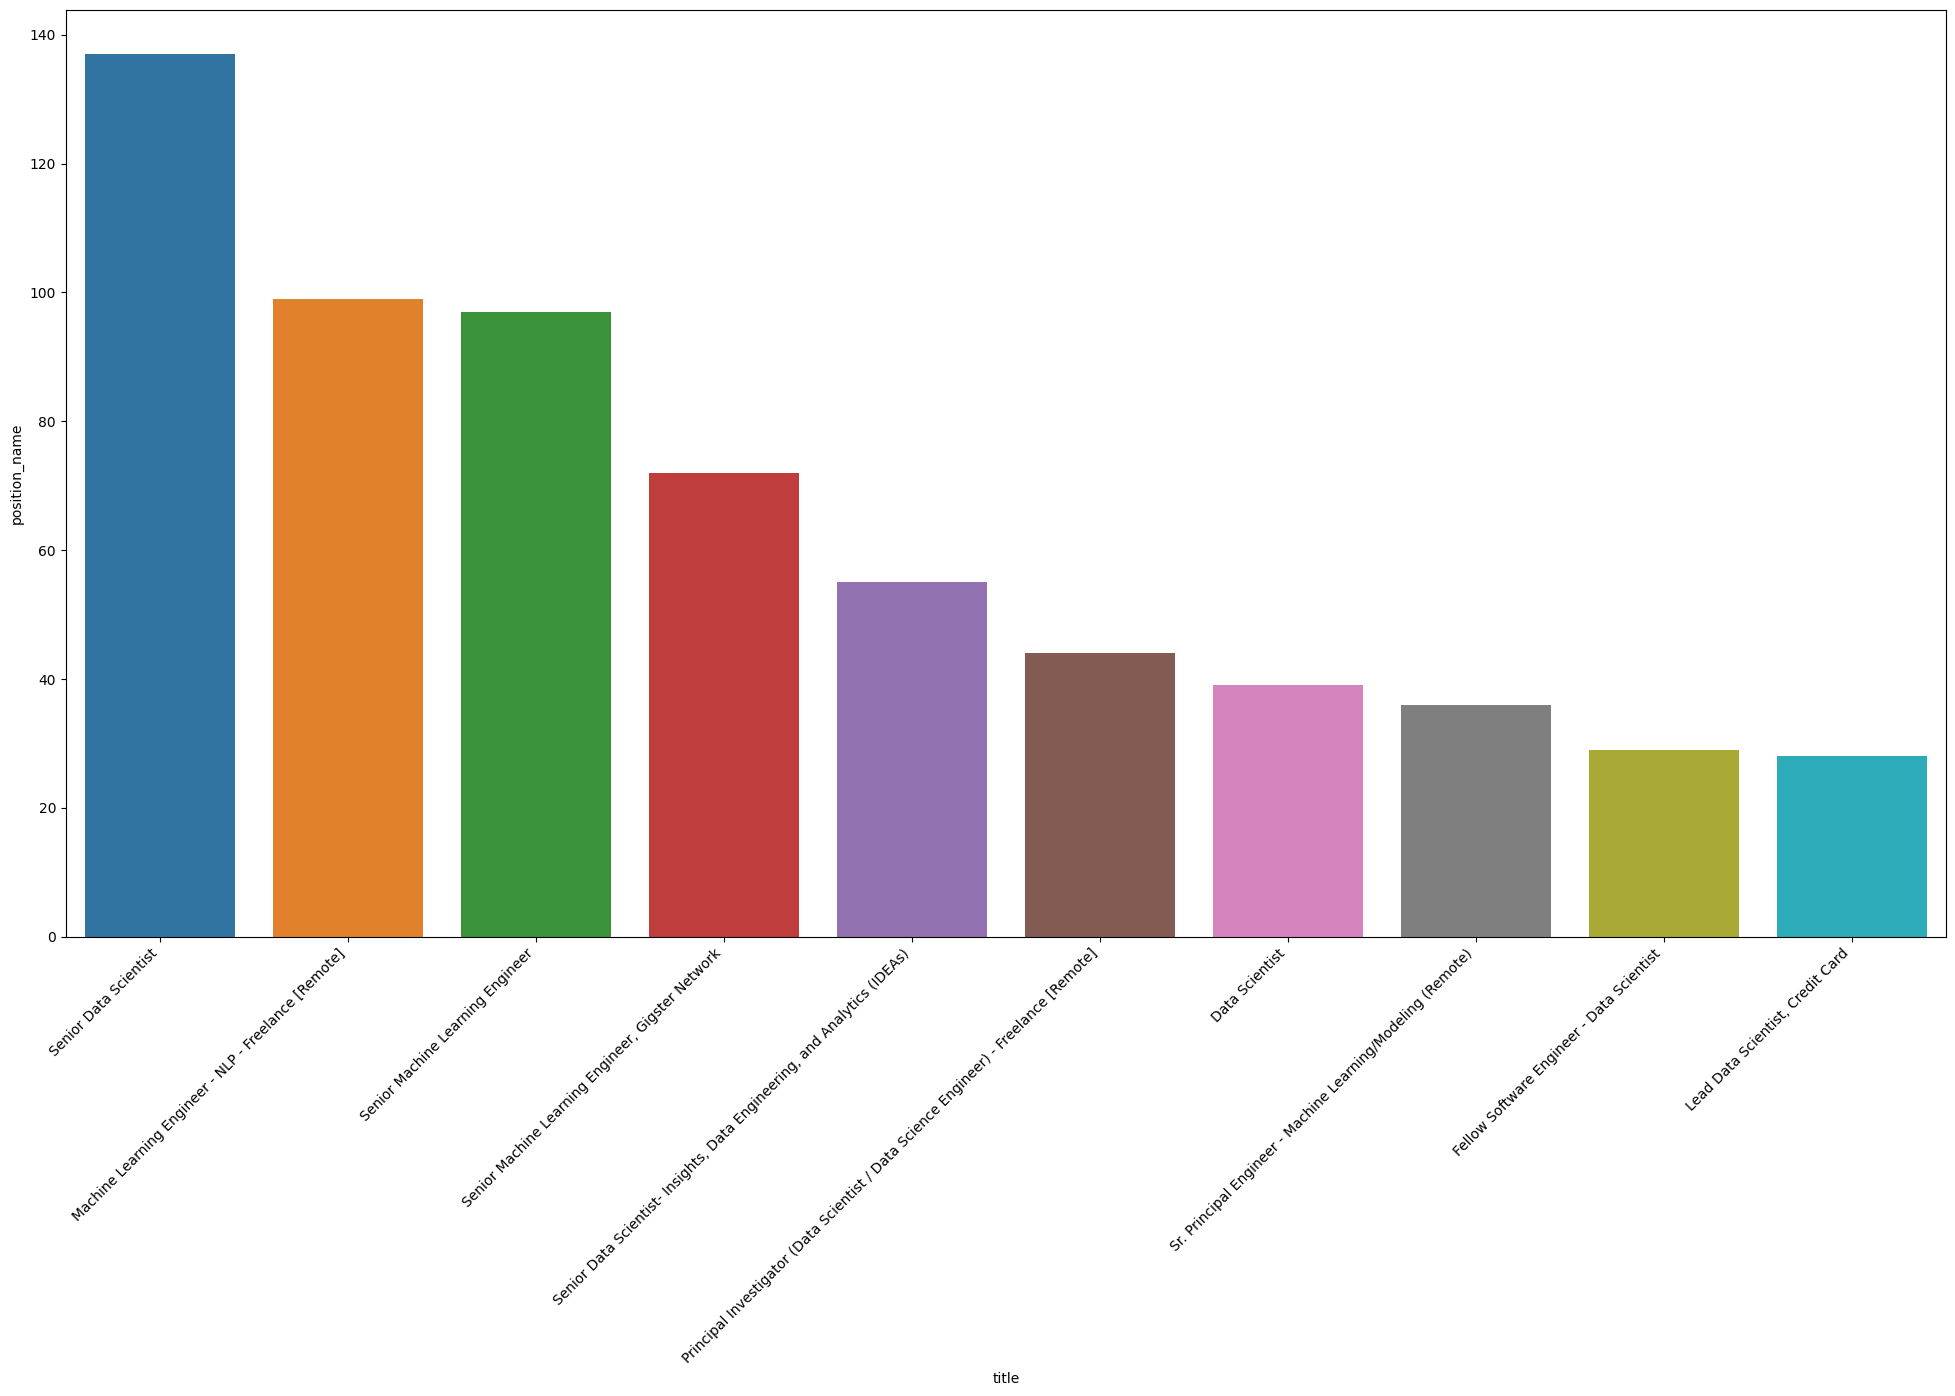

In [28]:
top_10_jobs_name = df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(x = top_10_jobs_name.index , y = top_10_jobs_name)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

Experiences required

In [29]:
df_target.groupby('experience_required').count()['title'].sort_values(ascending=False)

experience_required
Mid-Senior level    2001
Associate            102
Name: title, dtype: int64

All contract type

In [30]:
df_target.groupby('contract_type').count()['title'].sort_values(ascending=False)

contract_type
Full-time    2095
Contract        8
Name: title, dtype: int64

All different Function names

In [31]:
df_target.groupby('function_name').count()['title'].sort_values(ascending=False)

function_name
Engineering and Information Technology           1108
Other                                             254
Research, Analyst, and Information Technology     142
Information Technology                             98
Engineering                                        80
                                                 ... 
Information Technology and Marketing                1
Information Technology and Other                    1
Information Technology and Product Management       1
Information Technology and Project Management       1
Strategy/Planning                                   1
Name: title, Length: 88, dtype: int64

All different company sectors

In [32]:
df_target.groupby('company_sector').count()['title'].sort_values(ascending=False)

company_sector
Technology, Information and Internet                                                         349
Software Development                                                                         273
Staffing and Recruiting                                                                      170
IT Services and IT Consulting                                                                134
Business Consulting and Services                                                             119
                                                                                            ... 
Online Audio and Video Media and Retail                                                        1
Defense and Space Manufacturing, Government Relations Services, and Airlines and Aviation      1
Consumer Electronics                                                                           1
Real Estate                                                                                    1
IT Services and

All different locations

In [33]:
df_target.groupby('location').count()['title'].sort_values(ascending=False)

location
United States                                                614
San Francisco, CA                                            116
New York, NY                                                  93
Seattle, WA                                                   60
Boston, MA                                                    57
                                                            ... 
Kuala Lumpur, Federal Territory of Kuala Lumpur, Malaysia      1
Kyrgyzstan                                                     1
Lafayette, LA                                                  1
Lake County, IL                                                1
Łódź, Łódzkie, Poland                                          1
Name: title, Length: 335, dtype: int64

Example of description

In [28]:
df_target['description'].iloc[0]

"About the location Alcoa’s U.S. portfolio includes Alcoa's corporate headquarters (ACC), Alcoa's Technology Center (ATC), four smelters, hydroelectric power and a calcined coke plant. Every day is a new and exciting challenge at the Alcoa Technical Center in New Kensington, PA, just north of Pittsburgh; whether working virtually, on-site, or a hybrid of the two, we develop new technologies with our Breakthrough Technologies team that has the potential to impact the life of millions of people, and foster the sustainable footprint from Alcoa to the world. It was here where we developed the technology recently announced in partnership with Rio Tinto, called ELYSIS™, where we will produce aluminum with ZERO emission of greenhouse gases. In fact, we will actually be generating oxygen to our atmosphere during the aluminum production process– a revolution to the aluminum industry!About The Job Alcoa Technical Center (ATC) is the flagship light metal research center of Alcoa situated in New K

In [29]:
df_target['description'].iloc[1]

'The role: At Big Hat Biosciences our machine learning stack is tightly integrated with a high-throughput wetlab to rapidly design and validate ML-engineered antibodies. The Machine Learning Scientist* will work to advance the state of the art at each step in this integrated, iterative antibody optimization platform, improving the effectiveness with which it can be used to design new therapeutics to address unmet patient need.At Big Hat we believe in titles that commensurate with skill set, relative organizational impact, and value contribution; more experienced candidates are encouraged to apply, with the understanding that responsibilities and title would adjust as appropriate. Job Responsibilities Rapidly design, implement, and evaluate predictive machine learning models of diverse antibody biophysical properties, for dataset scales from hundreds to millions, to support Big Hat’s therapeutic portfolio.Develop and implement improved active learning / bayesian optimization methodologi

# Data Science

## Spacy personalized NER

In [37]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

In [38]:
#gensim
import gensim
from gensim import corpora

In [39]:
#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud

In [40]:
#Data loading/ Data manipulation

import numpy as np
import jsonlines

In [41]:
#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
#warning
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Loading spaCy model

In [43]:
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")

In [44]:
# skill_pattern_path = "jz_skill_patterns.jsonl"
skill_pattern_path = "personalized_ner.jsonl"

In [45]:
#Entity Ruler
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

### Functions

In [106]:
def get_entities(text, entity_label):
    """Extracts entities of a specific label from the given text.

    Args:
        text (str): The text from which entities need to be extracted.
        entity_label (str): The label of the entities to extract.

    Returns:
        list: A list of entities extracted from the text with the specified label.
    """
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ == entity_label:
            entities.append(ent.text)
    return entities

def get_all_entities(text):
    """Extracts all entities  from the given text.

    Args:
        text (str): The text from which entities need to be extracted.

    Returns:
        list: A list of entities extracted from the text with the specified label.
    """
    doc = nlp(text)

    skill = []
    contract = []
    education = []
    constraints = []
    experience = []

    for ent in doc.ents:
        if ent.label_ == "SKILL":
            skill.append(ent.text)
        if ent.label_ == "CONTRACT":
            contract.append(ent.text)
        if ent.label_ == "EDUCATION":
            education.append(ent.text)
        if ent.label_ == "CONSTRAINTS":
            constraints.append(ent.text)
        if ent.label_ == "EXPERIENCE":
            experience.append(ent.text)

    return skill, contract, education, constraints, experience

def get_skill(text):
    """Extracts all entities  from the given text.

    Args:
        text (str): The text from which entities need to be extracted.

    Returns:
        list: A list of entities extracted from the text with the specified label.
    """
    doc = nlp(text)

    skill = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            skill.append(ent.text)
    return skill

def unique_skills(x):
    return list(set(x))

### Preprocess

In [47]:
df_job['description']

0       Senior Research Scientist - RWEAre you looking...
1       REMOTE (US/Canada Residing people only, with w...
2       My client is at the intersection of advertisin...
3       About the locationAlcoa’s U.S. portfolio inclu...
4       The role: At BigHat Biosciences our machine le...
                              ...                        
2727    Want to join a rapidly growing AI-driven finte...
2728    If you are passionate about 1:1 customer marke...
2729    You could be the one who changes everything fo...
2730    Join our team as a Lead Supply Chain Data Scie...
2731    La sociétéLancée en 2012, cette startup est de...
Name: description, Length: 2732, dtype: object

In [48]:
data = df_job.copy()
#data = df_job.tail(50)

In [49]:
clean = []
#for i in range(data.shape[0]):
for i in range(len(data)):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["description"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [50]:
clean

['senior research scientist rweare looking work dynamic team industry leading professional heor space passion leading real world evidence study improve healthcare outcome worldwide real world evidence team hiring senior research scientist join team research professional conducting client study pharmacy biotech space operating thought leader problem solver data expert fully remote position youyou experienced health economics outcome research consultant understanding pharmaceutical industry medical affair anticipate client consideration oversee activity database analysis including literature review data feasibility assessment study protocol analytic dataset creation data analysis deliverable creation anticipate identify consideration relevant implementation various approach including potential facilitator barrier successful project task execution perform analysis independently comfortable making recommendation client team member study direction comfortable presenting interacting client a

### Extract skilss

In [51]:
data['clean_description'] = clean
data["clean_description"] = data["clean_description"].str.lower()

In [52]:
#results receive all the entities extracted
result = data["clean_description"].apply(lambda text: get_all_entities(text))

In [53]:
# Access the extracted entities from the result
all_skills = result.apply(lambda x: x[0])
all_contracts = result.apply(lambda x: x[1])
all_educations = result.apply(lambda x: x[2])
all_constraints = result.apply(lambda x: x[3])
all_experiences = result.apply(lambda x: x[4])

In [54]:
data["skills"] = all_skills
data["contract"] = all_contracts
data["education"] = all_educations
data["constraints"] = all_constraints
data["experience"] = all_experiences

In [ ]:
# # Apply the function to the data
# data['clean_description'] = clean
# data["clean_description"] = data["clean_description"].str.lower()
# data["skills"] = data["clean_description"].apply(lambda x: get_entities(x, "SKILL"))
# data["contract"] = data["clean_description"].apply(lambda x: get_entities(x, "CONTRACT"))
# data["education"] = data["clean_description"].apply(lambda x: get_entities(x, "EDUCATION"))
# data["constraints"] = data["clean_description"].apply(lambda x: get_entities(x, "CONSTRAINTS"))
# data["experience"] = data["clean_description"].apply(lambda x: get_entities(x, "EXPERIENCE"))

# data["skills"] = data["skills"].apply(lambda x: ', '.join(x).strip('[]'))
# data["contract"] = data["contract"].apply(lambda x: ', '.join(x).strip('[]'))
# data["education"] = data["education"].apply(lambda x: ', '.join(x).strip('[]'))
# data["constraints"] = data["constraints"].apply(lambda x: ', '.join(x).strip('[]'))
# data["experience"] = data["experience"].apply(lambda x: ', '.join(x).strip('[]'))


In [55]:
data

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience
0,nan,nan,nan,nan,nan,nan,nan,nan,Senior Research Scientist - RWEAre you looking...,https://www.linkedin.com/jobs/view/3447261797,2023-04-16 20:42:01.921947,senior research scientist rweare looking work ...,"[database, data analysis, component, component...",[],[],[],[]
1,nan,nan,nan,nan,nan,nan,nan,nan,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572911358,2023-04-16 20:42:31.120303,remote u canada residing people work permit pa...,"[ai, mode, google, machine learning, deep lear...",[],[],"[residing people, work permit]",[]
2,nan,nan,nan,nan,nan,nan,nan,nan,My client is at the intersection of advertisin...,https://www.linkedin.com/jobs/view/3554690649,2023-04-16 20:42:56.422566,client intersection advertising marketing usin...,"[advertising, marketing, ai, machine learning]",[],[],[],[]
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the locationAlcoa’s U.S. portfolio inclu...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068,locationalcoa u portfolio includes alcoa corpo...,"[data analysis, computational model, engineeri...",[],[master],[],[]
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At BigHat Biosciences our machine le...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148,role bighat bioscience machine learning stack ...,"[machine learning, throughput, design, ml, mac...",[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,Senior Data Scientist - (With experience in th...,"Dublin, County Dublin, Ireland",Recruiters.ie,Senior Data Scientist - (With experience in th...,Mid-Senior level,Full-time,Engineering and Management,Software Development,Want to join a rapidly growing AI-driven finte...,https://www.linkedin.com/jobs/view/3663427492,2023-07-15 03:20:16.781901,want join rapidly growing ai driven fintech st...,"[ai, play, accounting, machine learning, artif...",[],[],[],[]
2728,Data Scientist (Marketing),United States,Sud Recruiting,Data Scientist (Marketing),Mid-Senior level,Full-time,"Analyst, Strategy/Planning, and Product Manage...",Advertising Services,If you are passionate about 1:1 customer marke...,https://www.linkedin.com/jobs/view/3661532596,2023-07-15 03:17:18.098322,passionate 1 1 customer marketing personalizat...,"[marketing, marketing, ai, analytics, machine ...",[long term],[master],[],[]
2729,Lead Machine Learning Engineer - remote,"St Louis, MO",RemoteWorker US,Lead Machine Learning Engineer - remote,Mid-Senior level,Full-time,Engineering and Information Technology,Staffing and Recruiting,You could be the one who changes everything fo...,https://www.linkedin.com/jobs/view/3666200502,2023-07-15 03:24:56.719220,could one change everything 28 million member ...,"[design, ai, machine learning, testing, machin...",[],[bachelor],[],[]
2730,Lead Supply Chain Data Scientist - Remote | WFH,"Blacklick Estates, OH",Get It Recruit - Transportation,Lead Supply Chain Data Scientist - Remote | WFH,Mid-Senior level,Full-time,Engineering and Information Technology,Human Resources Services,Join our team as a Lead Supply Chain Data Scie...,https://www.linkedin.com/jobs/view/3660394658,2023-07-15 03:38:18.014391,join team lead supply chain data scientist loo...,"[business, amp, analytics, amp, data science, ...",[],[bachelor],[],[]


## Visualizations

In [56]:
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

In [57]:
#most relevant skilss
data_exploded = data.explode('skills')
count_data = data_exploded.groupby(['title', 'skills']).size().reset_index(name='count')
count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,skills,count
292,machine learning,5773
59,business,5575
8,ai,3716
448,software,3384
138,data science,2936
469,support,2805
16,amp,2788
311,ml,2729
183,engineering,2340
156,design,2298


In [58]:
#most relevant contracts
data_exploded = data.explode('contract')
count_data = data_exploded.groupby(['title', 'contract']).size().reset_index(name='count')
count_data.groupby('contract').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,contract,count
4,long term,485
1,contract,395
0,c2c,322
6,short term,282
3,freelance,151
7,temporary,26
5,project based,9
8,w2,7
2,fixed term,1


In [59]:
#most relevant constraints
data_exploded = data.explode('constraints')
count_data = data_exploded.groupby(['title', 'constraints']).size().reset_index(name='count')
count_data.groupby('constraints').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,constraints,count
2,work permit,554
1,residing people,553
0,green card,3


In [60]:
#most relevant education
data_exploded = data.explode('education')
count_data = data_exploded.groupby(['title', 'education']).size().reset_index(name='count')
count_data.groupby('education').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,education,count
1,master,600
0,bachelor,462


In [61]:
#Filter to get only ML and DS name titles
key_word_ml = 'learning'
key_word_ds = 'scientist'

#check if a column contain a word
ml_patern = re.compile(rf'\b{re.escape(key_word_ml)}\b', flags=re.IGNORECASE)
ds_patern = re.compile(rf'\b{re.escape(key_word_ds)}\b', flags=re.IGNORECASE)

df_target = data.loc[(data['title'].str.contains(ds_patern)) | (data['title'].str.contains(ml_patern))]
df_target

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the locationAlcoa’s U.S. portfolio inclu...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068,locationalcoa u portfolio includes alcoa corpo...,"[data analysis, computational model, engineeri...",[],[master],[],[]
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At BigHat Biosciences our machine le...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148,role bighat bioscience machine learning stack ...,"[machine learning, throughput, design, ml, mac...",[],[],[],[]
5,PK Research Scientist 2 - Remote,United States,Talentify.io,PK Research Scientist 2 - Remote,Mid-Senior level,Full-time,Other,Human Resources Services,Talentify helps candidates around the world to...,https://www.linkedin.com/jobs/view/3572871277,2023-04-16 22:33:27.582860,talentify help candidate around world discover...,"[finance, play, support, material, software, d...",[contract],[],[],[]
6,PK Research Scientist 2 - Remote,United States,Talentify.io,PK Research Scientist 2 - Remote,Mid-Senior level,Full-time,Other,Human Resources Services,Talentify helps candidates around the world to...,https://www.linkedin.com/jobs/view/3572871277,2023-04-17 03:08:02.683100,talentify help candidate around world discover...,"[finance, play, support, material, software, d...",[contract],[],[],[]
7,Research Scientist - Software Engineering (Rem...,United States,Talentify.io,Research Scientist - Software Engineering (Rem...,Mid-Senior level,Full-time,Other,Human Resources Services,Talentify helps candidates around the world to...,https://www.linkedin.com/jobs/view/3578251554,2023-04-21 03:11:31.082683,talentify help candidate around world discover...,"[software, collaboration, machine learning, na...",[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,Senior Data Scientist - (With experience in th...,"Dublin, County Dublin, Ireland",Recruiters.ie,Senior Data Scientist - (With experience in th...,Mid-Senior level,Full-time,Engineering and Management,Software Development,Want to join a rapidly growing AI-driven finte...,https://www.linkedin.com/jobs/view/3663427492,2023-07-15 03:20:16.781901,want join rapidly growing ai driven fintech st...,"[ai, play, accounting, machine learning, artif...",[],[],[],[]
2728,Data Scientist (Marketing),United States,Sud Recruiting,Data Scientist (Marketing),Mid-Senior level,Full-time,"Analyst, Strategy/Planning, and Product Manage...",Advertising Services,If you are passionate about 1:1 customer marke...,https://www.linkedin.com/jobs/view/3661532596,2023-07-15 03:17:18.098322,passionate 1 1 customer marketing personalizat...,"[marketing, marketing, ai, analytics, machine ...",[long term],[master],[],[]
2729,Lead Machine Learning Engineer - remote,"St Louis, MO",RemoteWorker US,Lead Machine Learning Engineer - remote,Mid-Senior level,Full-time,Engineering and Information Technology,Staffing and Recruiting,You could be the one who changes everything fo...,https://www.linkedin.com/jobs/view/3666200502,2023-07-15 03:24:56.719220,could one change everything 28 million member ...,"[design, ai, machine learning, testing, machin...",[],[bachelor],[],[]
2730,Lead Supply Chain Data Scientist - Remote | WFH,"Blacklick Estates, OH",Get It Recruit - Transportation,Lead Supply Chain Data Scientist - Remote | WFH,Mid-Senior level,Full-time,Engineering and Information Technology,Human Resources Services,Join our team as a Lead Supply Chain Data Scie...,https://www.linkedin.com/jobs/view/3660394658,2023-07-15 03:38:18.014

Most common titles

In [62]:
df_target.groupby(['title']).size().reset_index(name='count').sort_values('count',ascending=False).head(20)

,title,count
362,Senior Data Scientist,140
206,Machine Learning Engineer - NLP - Freelance [R...,99
447,Senior Machine Learning Engineer,98
469,"Senior Machine Learning Engineer, Gigster Network",72
423,"Senior Data Scientist- Insights, Data Engineer...",55
69,Data Scientist,46
256,Principal Investigator (Data Scientist / Data ...,44
591,Sr. Principal Engineer - Machine Learning/Mode...,36
183,"Lead Data Scientist, Credit Card",30
136,Fellow Software Engineer - Data Scientist,29


Most common skills

In [67]:
data_exploded = df_target.explode('skills')
count_data = data_exploded.groupby(['title', 'skills']).size().reset_index(name='count')
count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,skills,count
270,machine learning,5706
54,business,5351
129,data science,2934
289,ml,2729
416,software,2728
436,support,2549
8,ai,2505
15,amp,2447
173,engineering,2144
353,python,1928


In [98]:
#percentual calculation
view = count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False)
view['percentual%'] = round((view['count'] / view['count'].sum())*100,2)
view = view.sort_values('count',ascending=False).head(50)
#view = count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False).head(50)

In [92]:
view['count'].sum()

62878

In [101]:
fig = px.scatter(view, x='skills', y='percentual%', size='percentual%')

fig.update_layout(
    xaxis=dict(
        title='Skills',
        tickangle=45
    ),
    yaxis=dict(
        title='%'
    ),
    title='Skills Distribution'
)

fig.show()

In [83]:
sent = nlp(data["description"].iloc[-2])
displacy.render(sent, style="ent", jupyter=True)

In [84]:
#Dependency Parsing
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

In [85]:
Job_Category = data["title"].unique()
Job_Category

array(['nan', 'Research Scientist - CFD Modeler (Flexible)',
       'Machine Learning Scientist (Remote)',
       'PK Research Scientist 2 - Remote',
       'Research Scientist - Software Engineering (Remote) ($112000.00 - $179000.00 / year)',
       'PK Research Scientist 2 - Remote ($120000.00 / year)',
       'Research Scientist - Software Engineering (Remote Option) ($112000.00 - $179000.00 / year)',
       'Senior Research Scientist - Software Engineering (Remote Option) ($146000.00 - $234000.00 / year)',
       'On-Call Research Scientist (REMOTE ROLE) ($68325.00 - $116152.00 / year)',
       'Research Scientist, Indigenous Communities (REMOTE ROLE) ($68325.00 - $116152.00 / year)',
       'Senior Research Scientist, Justice & Victim Services (REMOTE LOCATION) ($68325.00 - $116152.00 / year)',
       'Principal Research Scientist, Applied AI, Science',
       'Senior Research Scientist, Applied AI, Science',
       'Sr. Research Scientist- RWE', 'Sr. Research Scientist- Strategy'

Text(0.5, 1.0, 'Most Used Words in DS and ML jobs')

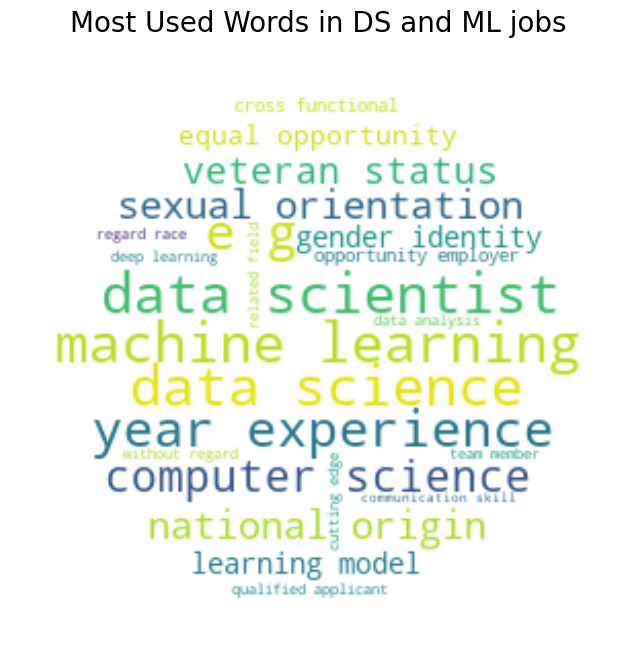

In [89]:
text = ""
#for i in data[data["title"] == Job_Category]["clean_description"].values:
for i in df_target["clean_description"].values:
    text += i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in DS and ML jobs", fontsize=20)

### Check the Match Score with one job and your skills

In [102]:
input_job = data.iloc[-2]['clean_description']

In [103]:
sent = nlp(data["description"].iloc[-2])
displacy.render(sent, style="ent", jupyter=True)

In [118]:
req_skills = ['data science', 'engineering', 'python', 'gcp']
resume_skills = unique_skills(get_skill(input_job))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"The current job requirement is {match}% matched to your skills")

The current job requirement is 75.0% matched to your skills


### Topic Modeling - LDA

In [119]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [120]:
documents = df_target['clean_description'].tolist()

# vectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# LDA
num_topics = 5  # Número de tópicos desejados
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# most relevant
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Número de palavras principais por tópico
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f"Top words for Topic #{topic_idx + 1}: {', '.join(top_words_list)}")

Top words for Topic #1: data, research, experience, work, team, health, clinical, development, support, including
Top words for Topic #2: research, project, experience, client, work, team, health, data, policy, analysis
Top words for Topic #3: data, product, team, experience, work, company, client, science, role, development
Top words for Topic #4: experience, learning, work, team, machine, software, ml, product, model, data
Top words for Topic #5: data, experience, science, learning, business, machine, team, solution, model, work


In [121]:
nested_list = df_target['skills'].tolist()
unique_list = list(set(sum(nested_list, [])))
documents = unique_list

# vectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# LDA
num_topics = 5  # Número de tópicos desejados
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# most relevant
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Número de palavras principais por tópico
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f"Top words for Topic #{topic_idx + 1}: {', '.join(top_words_list)}")

Top words for Topic #1: model, network, analysis, language, code, computing, component, recognition, regression, environment
Top words for Topic #2: processing, programming, detection, feature, tracking, signal, customer, image, document, text
Top words for Topic #3: data, information, management, web, design, analytics, aws, algorithm, natural, language
Top words for Topic #4: learning, machine, azure, interface, support, time, cloud, user, virtual, decision
Top words for Topic #5: data, engineering, management, computer, knowledge, analysis, science, business, extraction, model


## Extract years of experience required in description

### Using regex have better results then NER

In [122]:
# Define regular expression pattern to match the number of years
pattern = r'(\d+)\+?\s*(years|year|yrs|yr)'
matches = data['clean_description'].apply(lambda x: re.findall(pattern, x, re.IGNORECASE))

In [123]:
matches

0                  [(6, year)]
1                  [(5, year)]
2                           []
3                           []
4       [(2, year), (3, year)]
                 ...          
2727               [(5, year)]
2728                        []
2729               [(7, year)]
2730               [(7, year)]
2731                        []
Name: clean_description, Length: 2732, dtype: object

In [124]:
# Extract the matched numbers and convert them to integers
matches.apply(lambda x: [int(match[0]) for match in x])

0          [6]
1          [5]
2           []
3           []
4       [2, 3]
         ...  
2727       [5]
2728        []
2729       [7]
2730       [7]
2731        []
Name: clean_description, Length: 2732, dtype: object

In [125]:
data['years'] = matches.apply(lambda x: [int(match[0]) for match in x])

In [126]:
data

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience,years
0,nan,nan,nan,nan,nan,nan,nan,nan,Senior Research Scientist - RWEAre you looking...,https://www.linkedin.com/jobs/view/3447261797,2023-04-16 20:42:01.921947,senior research scientist rweare looking work ...,"[database, data analysis, component, component...",[],[],[],[],[6]
1,nan,nan,nan,nan,nan,nan,nan,nan,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572911358,2023-04-16 20:42:31.120303,remote u canada residing people work permit pa...,"[ai, mode, google, machine learning, deep lear...",[],[],"[residing people, work permit]",[],[5]
2,nan,nan,nan,nan,nan,nan,nan,nan,My client is at the intersection of advertisin...,https://www.linkedin.com/jobs/view/3554690649,2023-04-16 20:42:56.422566,client intersection advertising marketing usin...,"[advertising, marketing, ai, machine learning]",[],[],[],[],[]
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the locationAlcoa’s U.S. portfolio inclu...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068,locationalcoa u portfolio includes alcoa corpo...,"[data analysis, computational model, engineeri...",[],[master],[],[],[]
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At BigHat Biosciences our machine le...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148,role bighat bioscience machine learning stack ...,"[machine learning, throughput, design, ml, mac...",[],[],[],[],"[2, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,Senior Data Scientist - (With experience in th...,"Dublin, County Dublin, Ireland",Recruiters.ie,Senior Data Scientist - (With experience in th...,Mid-Senior level,Full-time,Engineering and Management,Software Development,Want to join a rapidly growing AI-driven finte...,https://www.linkedin.com/jobs/view/3663427492,2023-07-15 03:20:16.781901,want join rapidly growing ai driven fintech st...,"[ai, play, accounting, machine learning, artif...",[],[],[],[],[5]
2728,Data Scientist (Marketing),United States,Sud Recruiting,Data Scientist (Marketing),Mid-Senior level,Full-time,"Analyst, Strategy/Planning, and Product Manage...",Advertising Services,If you are passionate about 1:1 customer marke...,https://www.linkedin.com/jobs/view/3661532596,2023-07-15 03:17:18.098322,passionate 1 1 customer marketing personalizat...,"[marketing, marketing, ai, analytics, machine ...",[long term],[master],[],[],[]
2729,Lead Machine Learning Engineer - remote,"St Louis, MO",RemoteWorker US,Lead Machine Learning Engineer - remote,Mid-Senior level,Full-time,Engineering and Information Technology,Staffing and Recruiting,You could be the one who changes everything fo...,https://www.linkedin.com/jobs/view/3666200502,2023-07-15 03:24:56.719220,could one change everything 28 million member ...,"[design, ai, machine learning, testing, machin...",[],[bachelor],[],[],[7]
2730,Lead Supply Chain Data Scientist - Remote | WFH,"Blacklick Estates, OH",Get It Recruit - Transportation,Lead Supply Chain Data Scientist - Remote | WFH,Mid-Senior level,Full-time,Engineering and Information Technology,Human Resources Services,Join our team as a Lead Supply Chain Data Scie...,https://www.linkedin.com/jobs/view/3660394658,2023-07-15 03:38:18.014391,join team lead supply chain data scientist loo...,"[business, amp, analytics, amp, data science, ...",[],[bachelor],[],[],[7]


In [208]:
data.to_csv('ner_extracted.csv',index=False)

In [210]:
pd.read_csv('ner_extracted.csv')

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience,years
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senior Research Scientist - RWEAre you looking...,https://www.linkedin.com/jobs/view/3447261797,2023-04-16 20:42:01.921947,senior research scientist rweare looking work ...,"['database', 'data analysis', 'component', 'co...",[],[],[],[],[6]
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3572911358,2023-04-16 20:42:31.120303,remote u canada residing people work permit pa...,"['ai', 'mode', 'google', 'machine learning', '...",[],[],"['residing people', 'work permit']",[],[5]
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,My client is at the intersection of advertisin...,https://www.linkedin.com/jobs/view/3554690649,2023-04-16 20:42:56.422566,client intersection advertising marketing usin...,"['advertising', 'marketing', 'ai', 'machine le...",[],[],[],[],[]
3,Research Scientist - CFD Modeler (Flexible),"New Kensington, PA",Alcoa,Research Scientist - CFD Modeler (Flexible),Mid-Senior level,Full-time,Other,Mining,About the locationAlcoa’s U.S. portfolio inclu...,https://www.linkedin.com/jobs/view/3580699622,2023-04-25 03:02:52.797068,locationalcoa u portfolio includes alcoa corpo...,"['data analysis', 'computational model', 'engi...",[],['master'],[],[],[]
4,Machine Learning Scientist (Remote),"San Mateo, CA",BioSpace,Machine Learning Scientist (Remote),Mid-Senior level,Full-time,Other,Internet News,The role: At BigHat Biosciences our machine le...,https://www.linkedin.com/jobs/view/3573992159,2023-04-18 03:04:41.383148,role bighat bioscience machine learning stack ...,"['machine learning', 'throughput', 'design', '...",[],[],[],[],"[2, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,Senior Data Scientist - (With experience in th...,"Dublin, County Dublin, Ireland",Recruiters.ie,Senior Data Scientist - (With experience in th...,Mid-Senior level,Full-time,Engineering and Management,Software Development,Want to join a rapidly growing AI-driven finte...,https://www.linkedin.com/jobs/view/3663427492,2023-07-15 03:20:16.781901,want join rapidly growing ai driven fintech st...,"['ai', 'play', 'accounting', 'machine learning...",[],[],[],[],[5]
2728,Data Scientist (Marketing),United States,Sud Recruiting,Data Scientist (Marketing),Mid-Senior level,Full-time,"Analyst, Strategy/Planning, and Product Manage...",Advertising Services,If you are passionate about 1:1 customer marke...,https://www.linkedin.com/jobs/view/3661532596,2023-07-15 03:17:18.098322,passionate 1 1 customer marketing personalizat...,"['marketing', 'marketing', 'ai', 'analytics', ...",['long term'],['master'],[],[],[]
2729,Lead Machine Learning Engineer - remote,"St Louis, MO",RemoteWorker US,Lead Machine Learning Engineer - remote,Mid-Senior level,Full-time,Engineering and Information Technology,Staffing and Recruiting,You could be the one who changes everything fo...,https://www.linkedin.com/jobs/view/3666200502,2023-07-15 03:24:56.719220,could one change everything 28 million member ...,"['design', 'ai', 'machine learning', 'testing'...",[],['bachelor'],[],[],[7]
2730,Lead Supply Chain Data Scientist - Remote | WFH,"Blacklick Estates, OH",Get It Recruit - Transportation,Lead Supply Chain Data Scientist - Remote | WFH,Mid-Senior level,Full-time,Engineering and Information Technology,Human Resources Services,Join our team as a Lead Supply Chain Data Scie...,https://www.linkedin.com/jobs/view/3660394658,2023-07-15 03:38:18.014391,join team lead supply chain data scientist loo...,"['business', 'amp', 'analytics', 'amp', 'data ...",[],['bachelor'],[],[],[7]
